<h3 style="color:darkblue;">Hand Gesture Recognition</h3>

Building a Convolutional Neural Network (CNN) to classify American Sign Language (ASL) hand gestures.

- PyTorch: To build and train the deep learning model.
- OpenCV: For image processing.
- Image dataset: 10 ASL letter gestures (A, B, C, D, E, F, I, L, O, V)

<h4 style="color:darkred;">Setup & Data Exploration</h4>

In [1]:
# Import libraries

import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import transforms, datasets

import cv2

In [2]:
# Load and explore data

dataset_path = "./Gesture Image Data"

# Check if the folder exists
if not os.path.exists(dataset_path):
    print("Folder not found. Make sure:")
    print("- The folder name is exactly 'Gesture Image Data'")
    print("- It's in the same parent folder as this notebook")
else:
    print("Dataset folder found..")

# List all the gesture classes
classes = sorted([d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))])
print("\nGesture classes:")
for i, class_name in enumerate(classes):
    print(f"{i+1}. {class_name}")

# Count how many images in each class
print("\nNumber of images per class:")
total_images = 0
for class_name in classes:
    class_path = os.path.join(dataset_path, class_name)
    num_images = len([f for f in os.listdir(class_path) if f.endswith(('.jpg', '.jpeg', '.png'))])
    print(f"{class_name}: {num_images} images")
    total_images += num_images

print(f"\nTotal images: {total_images}")
print(f"Total classes: {len(classes)}")

Dataset folder found..

Gesture classes:
1. 0
2. 1
3. 2
4. 3
5. 4
6. 5
7. 6
8. 7
9. 8
10. 9
11. A
12. B
13. C
14. D
15. E
16. F
17. G
18. H
19. I
20. J
21. K
22. L
23. M
24. N
25. O
26. P
27. Q
28. R
29. S
30. T
31. U
32. V
33. W
34. X
35. Y
36. Z
37. _

Number of images per class:
0: 1500 images
1: 1500 images
2: 1500 images
3: 1500 images
4: 1500 images
5: 1500 images
6: 1500 images
7: 1500 images
8: 1500 images
9: 1500 images
A: 1500 images
B: 1500 images
C: 1500 images
D: 1500 images
E: 1500 images
F: 1500 images
G: 1500 images
H: 1500 images
I: 1500 images
J: 1500 images
K: 1500 images
L: 1500 images
M: 1500 images
N: 1500 images
O: 1500 images
P: 1500 images
Q: 1500 images
R: 1500 images
S: 1500 images
T: 1500 images
U: 1500 images
V: 1500 images
W: 1500 images
X: 1500 images
Y: 1500 images
Z: 1500 images
_: 1500 images

Total images: 55500
Total classes: 37


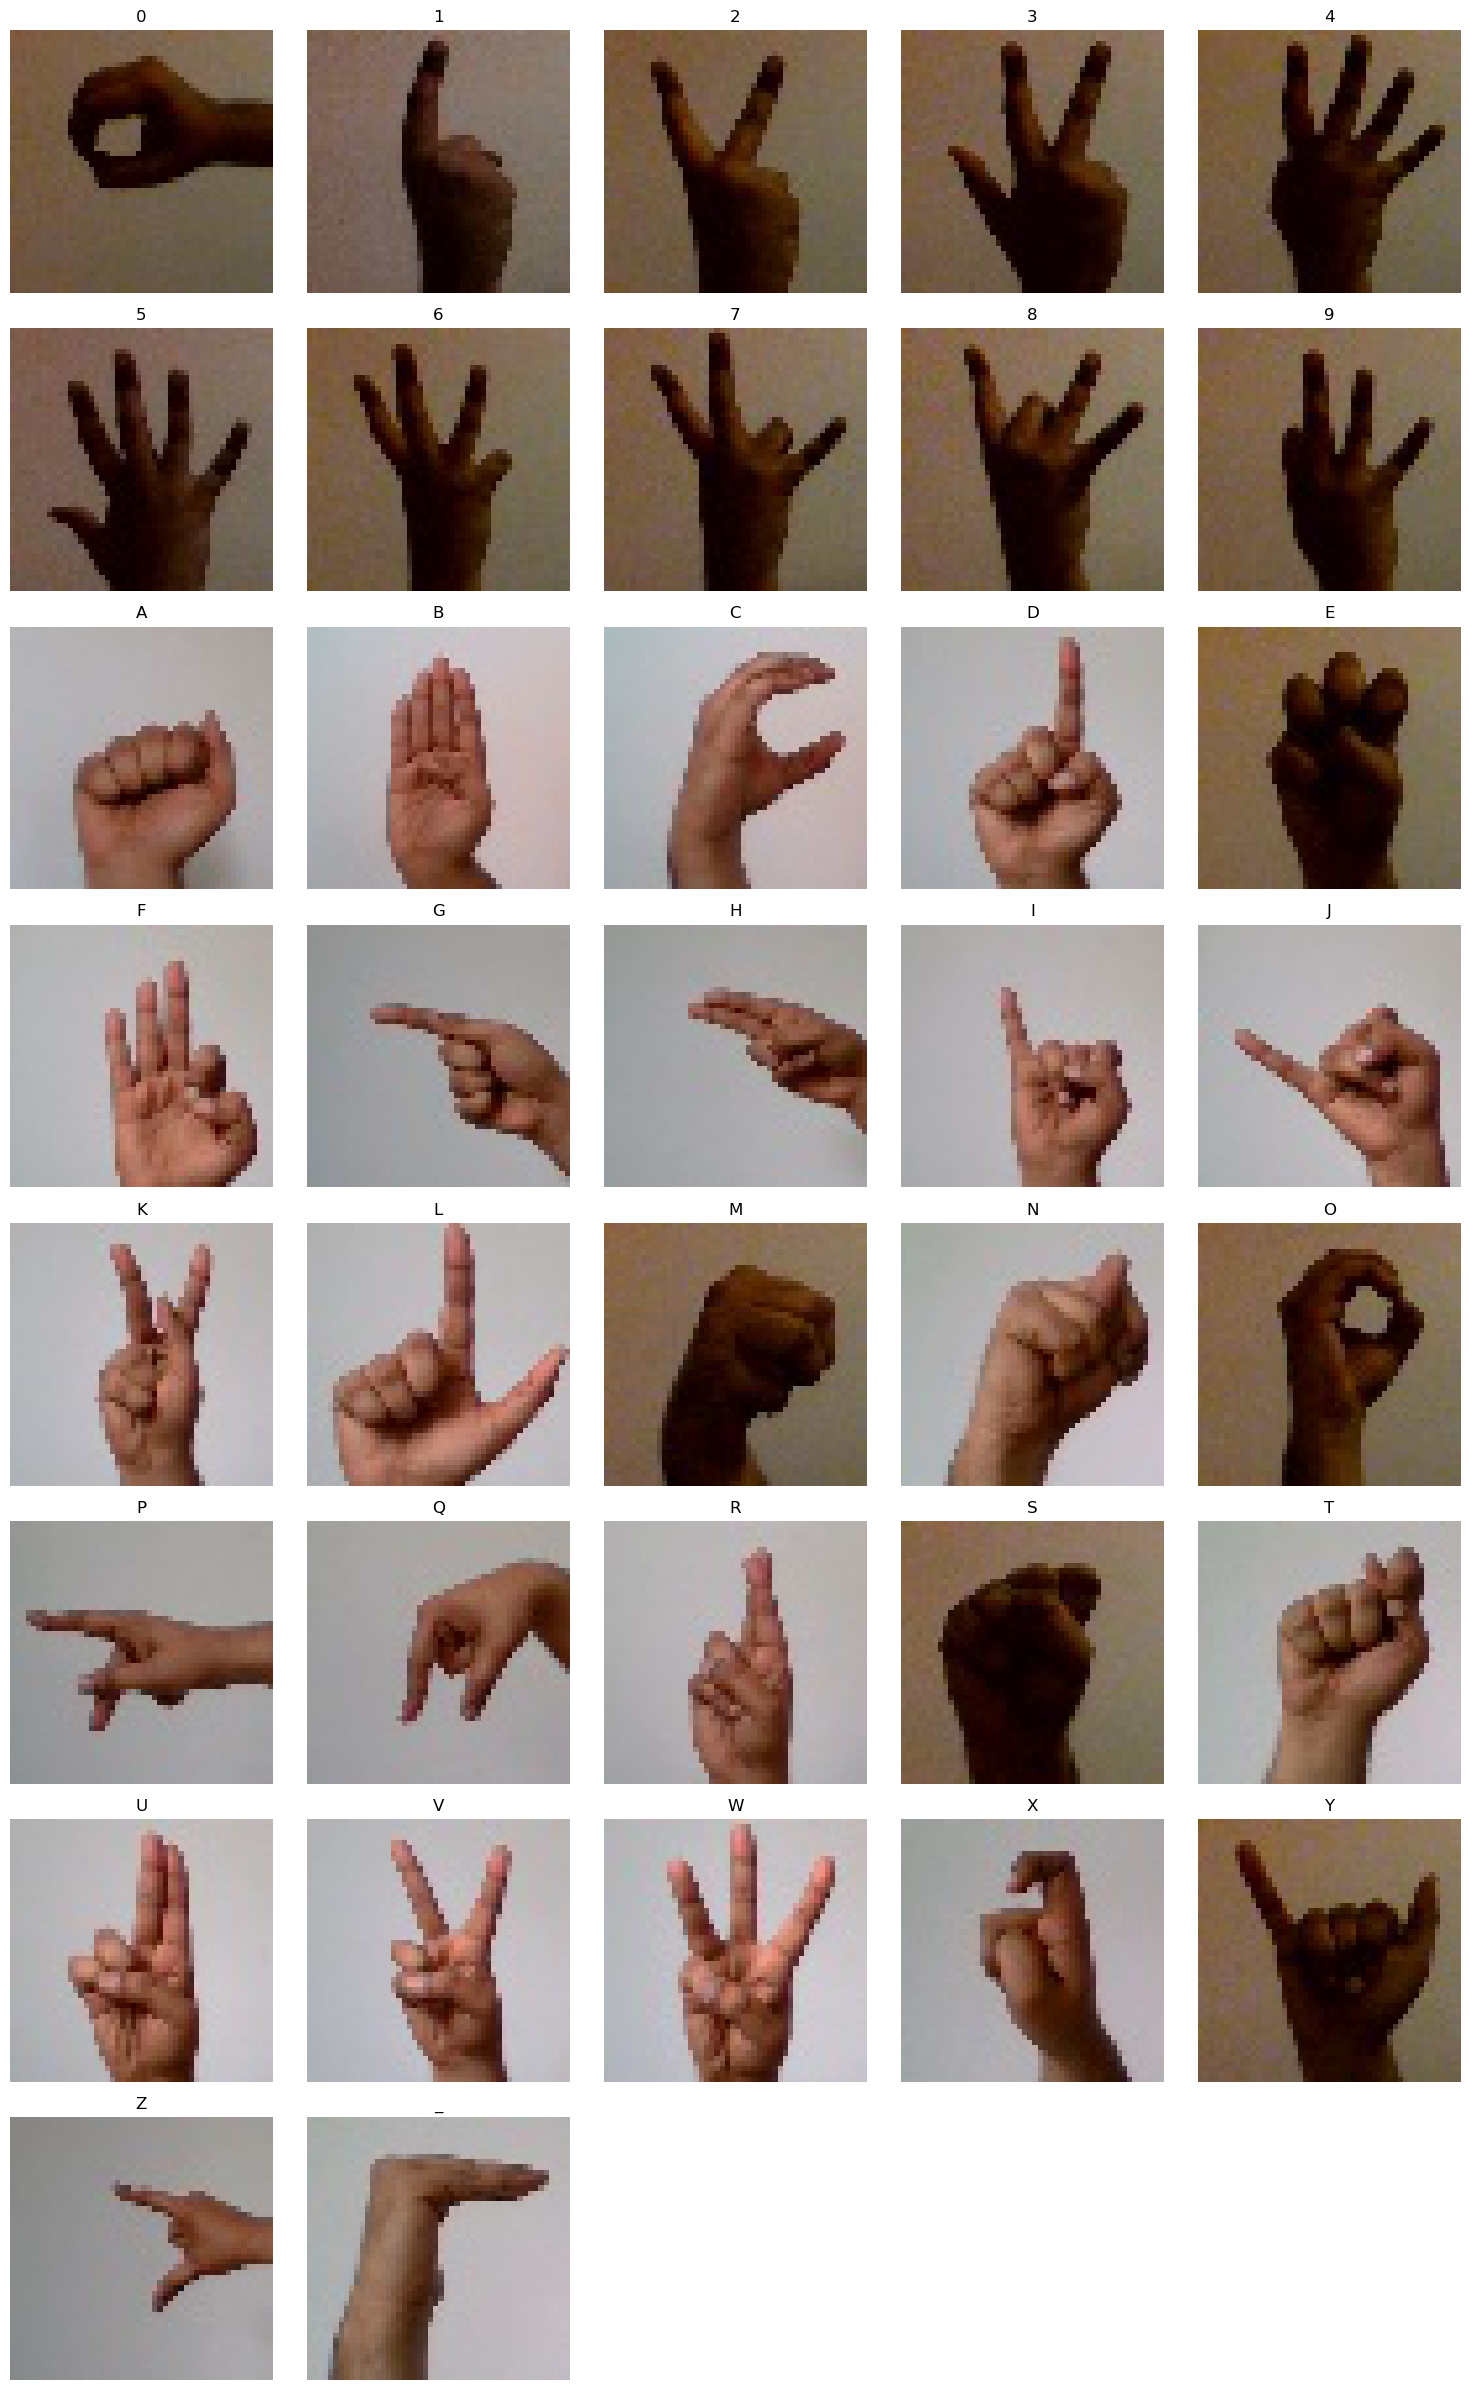

In [3]:
# Display sample image from each class

cols = 5
rows = (len(classes) + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(15, rows*3))
axes = axes.flatten()

for i, class_name in enumerate(classes):
    class_path = os.path.join(dataset_path, class_name)
    image_files = os.listdir(class_path)
    if image_files:
        sample_img_path = os.path.join(class_path, image_files[0])
        img = Image.open(sample_img_path)
        axes[i].imshow(img, cmap='gray' if img.mode == 'L' else None)
        axes[i].set_title(class_name)
        axes[i].axis('off')

for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

<h4 style="color:darkred;">Data Preparation (10 Classes)</h4>

We have many classes, but we'll start with just 10 to ensure training is efficient.

Selected classes: A, B, C, D, E, F, I, L, O, V

- Only load images from these 10 classes/folders
- Resize every image to 64x64 pixels (small but enough for learning shapes)
- Turn images into numbers (0-1 instead of 0-255) so the model learns better
- Split: 80% for training, 20% for testing

In [4]:
# Data Transformation

# # 10 chosen ASL letters
selected_classes = ['A', 'B', 'C', 'D', 'E', 'F', 'I', 'L', 'O', 'V']

from torchvision import transforms

# Augmentations for hand gestures
train_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomRotation(degrees=15),                     # Slight hand tilt
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Small shifts
    transforms.RandomAffine(degrees=0, scale=(0.9, 1.1)),      # Zoom in/out
    transforms.RandomHorizontalFlip(p=0.5),                    # Left/right hand (if applicable)
    transforms.ColorJitter(brightness=0.3, contrast=0.3),      # Lighting changes
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

test_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))         # Make values between -1 and 1 (helps model learn)
])

In [5]:
# Subset selection & Data Creation

from torch.utils.data import Dataset

class SelectedGestureDataset(Dataset):
    def __init__(self, root_dir, selected_classes, transform=None):
        self.root_dir = root_dir
        self.selected_classes = selected_classes
        self.transform = transform
        self.class_to_idx = {cls: idx for idx, cls in enumerate(sorted(selected_classes))}
        
        self.samples = []
        for cls in selected_classes:
            cls_path = os.path.join(root_dir, cls)
            if os.path.isdir(cls_path):
                for img_name in os.listdir(cls_path):
                    if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                        self.samples.append((os.path.join(cls_path, img_name), self.class_to_idx[cls]))
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert('L')
        if self.transform:
            image = self.transform(image)
        return image, label

# Create datasets with different transforms
train_dataset_full = SelectedGestureDataset(
    root_dir=dataset_path,
    selected_classes=selected_classes,
    transform=train_transforms
)

test_dataset = SelectedGestureDataset(
    root_dir=dataset_path,
    selected_classes=selected_classes,
    transform=test_transforms
)

print(f"Total images in train+val (augmented during training): {len(train_dataset_full)}")
print(f"Total images in test set: {len(test_dataset)}")
print("Labels: 0=A, 1=B, 2=C, 3=D, 4=E, 5=F, 6=I, 7=L, 8=O, 9=V")

Total images in train+val (augmented during training): 15000
Total images in test set: 15000
Labels: 0=A, 1=B, 2=C, 3=D, 4=E, 5=F, 6=I, 7=L, 8=O, 9=V


In [6]:
# Split and dataloaders

from torch.utils.data import random_split, DataLoader

# Split the augmented dataset into train and validation
train_size = int(0.85 * len(train_dataset_full))
val_size = len(train_dataset_full) - train_size

train_set, val_set = random_split(train_dataset_full, [train_size, val_size])

print(f"Training samples (with augmentation): {len(train_set)}")
print(f"Validation samples: {len(val_set)}")
print(f"Test samples (clean): {len(test_dataset)}")

# Dataloaders
batch_size = 32

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Training samples (with augmentation): 12750
Validation samples: 2250
Test samples (clean): 15000


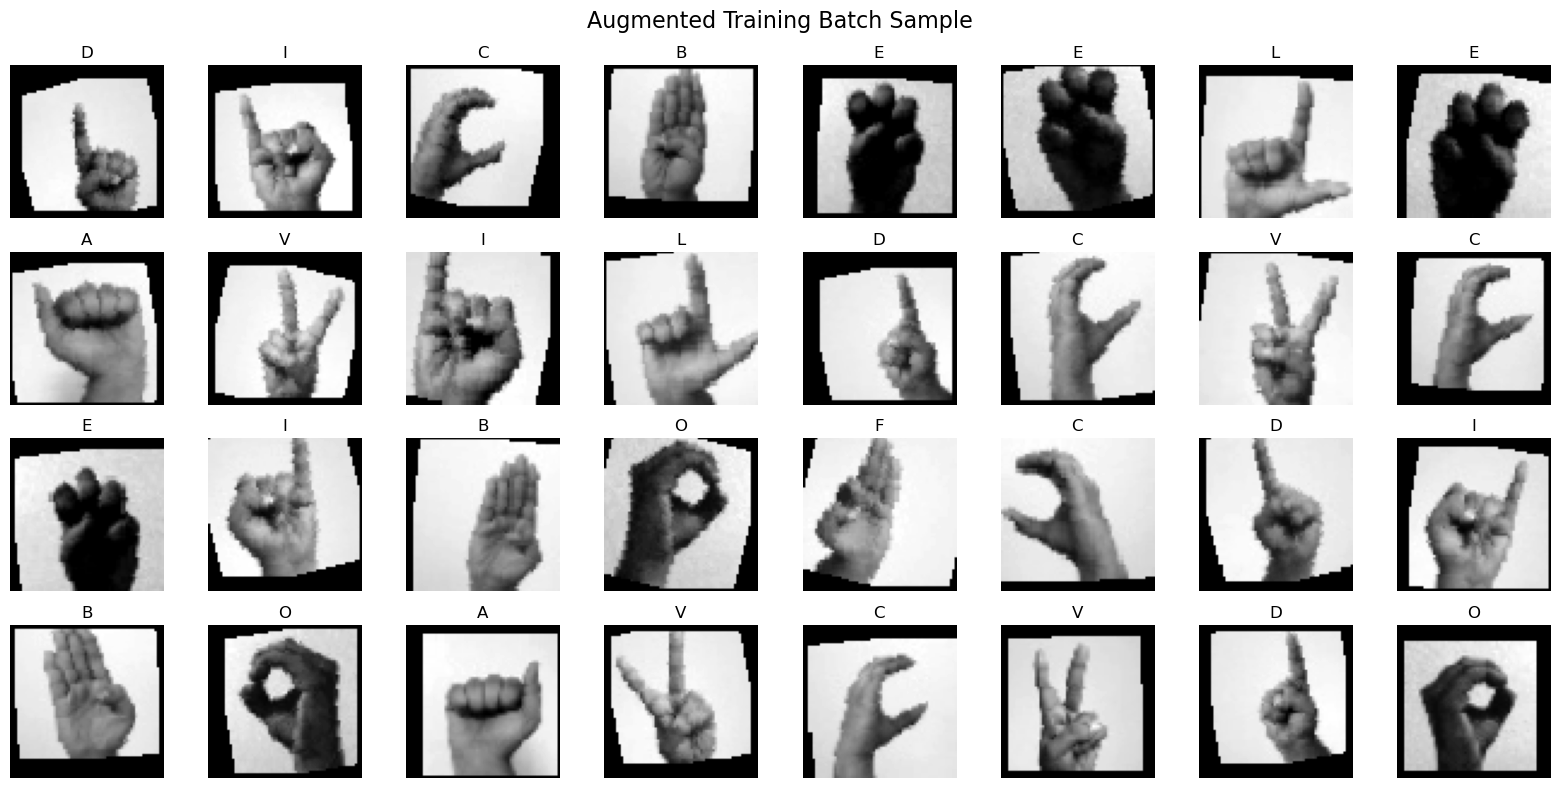

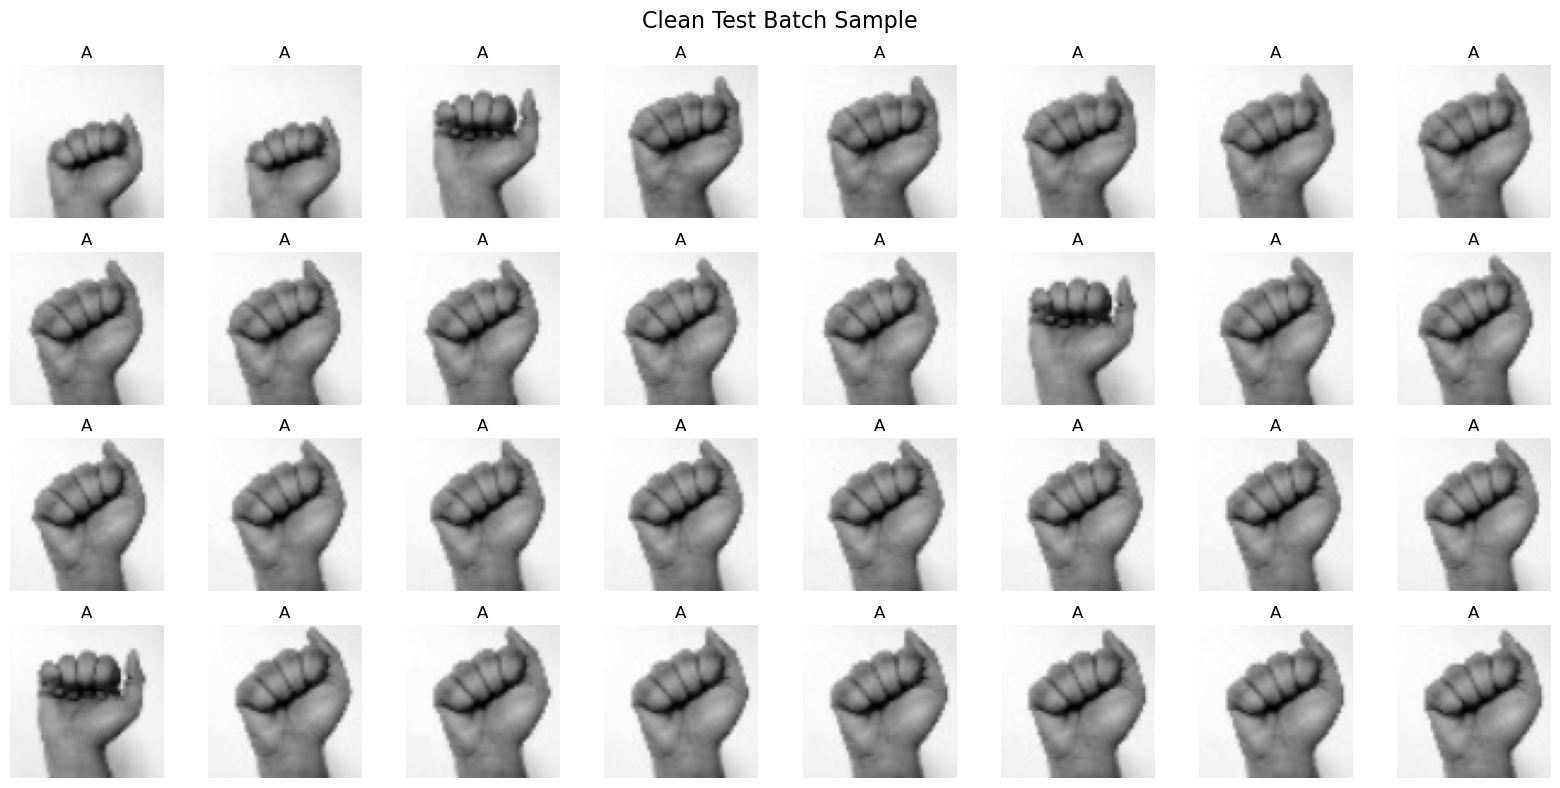

In [7]:
# Batch visualization of data images

def show_batch(loader, cols=8, title="Augmented Training Batch"):
    images, labels = next(iter(loader))
    
    # # Un-normalize & remove channel
    images = (images * 0.5 + 0.5).clamp(0, 1)
    images = images.squeeze(1)
    
    num_show = images.shape[0]
    rows = (num_show + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
    axes = axes.flatten() if rows > 1 else [axes] * num_show
    
    for i in range(num_show):
        axes[i].imshow(images[i], cmap='gray')
        label_name = selected_classes[labels[i].item()]
        axes[i].set_title(label_name, fontsize=12)
        axes[i].axis('off')
    
    # Hide empty subplots
    for j in range(num_show, len(axes)):
        axes[j].axis('off')
    
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

# Augmented batch
show_batch(train_loader, title="Augmented Training Batch Sample")

# Test batch
show_batch(test_loader, title="Clean Test Batch Sample")

<h4 style="color:darkred;">Build CNN Model</h4>

1. First layers: Detect simple patterns (edges, lines, curves)
2. Middle layers: Combine features (fingers, thumb position, holes (like in O))
3. Final layers: Decide or classify the pattern (eg, "This looks like letter A")

The CNN will have:
- 3 convolution blocks (detect features)
- Pooling (shrink image, focus on important parts)
- Fully connected layers at the end (make the final decision)

Input: grayscale images (1 channel), Output: 10 classes (A, B, C, …, V)

In [8]:
# Define CNN model

class HandGestureCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(HandGestureCNN, self).__init__()
        
        # Block 1: For basic edges
        self.block1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),  # Input: 1 channel, Output: 32 feature maps
            nn.ReLU(),                                   # Activation: makes it non-linear
            nn.MaxPool2d(2)                              # Shrink: 64x64 to 32x32
        )
        
        # Block 2: Detect curves and finger shapes
        self.block2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)                              # 32x32 to 16x16
        )
        
        # Block 3: Detect more complex patterns
        self.block3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)                             # 16x16 to 8x8
        )
        
        # Fully connected layers
        self.classifier = nn.Sequential(
            nn.Flatten(),                 
            nn.Linear(128 * 8 * 8, 512),
            nn.ReLU(),
            nn.Dropout(0.5),      
            nn.Linear(512, num_classes) 
        )
    
    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.classifier(x)
        return x

# Create the model
model = HandGestureCNN(num_classes=10)

# Move to GPU if available, else CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

print(f"Model works on {device}..")
print(model)

Model works on cpu..
HandGestureCNN(
  (block1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=8192, out_features=512, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [9]:
# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

<h4 style="color:darkred;">Train the Model</h4>

In [10]:
# Training & Validation Monitoring

num_epochs = 15
train_losses = []
train_accuracies = []
val_accuracies = []

print("Starting training..\n")

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(train_acc)
    
    model.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
    
    val_acc = 100 * val_correct / val_total
    val_accuracies.append(val_acc)
    
    print(f"Epoch [{epoch+1:2d}/{num_epochs}] | "
          f"Train Loss: {epoch_loss:.4f} | "
          f"Train Acc: {train_acc:6.2f}% | "
          f"Val Acc: {val_acc:6.2f}%")

print("\nTraining finished..")

Starting training..

Epoch [ 1/15] | Train Loss: 0.7785 | Train Acc:  70.82% | Val Acc:  95.78%
Epoch [ 2/15] | Train Loss: 0.1527 | Train Acc:  94.95% | Val Acc:  98.71%
Epoch [ 3/15] | Train Loss: 0.0730 | Train Acc:  97.66% | Val Acc:  99.11%
Epoch [ 4/15] | Train Loss: 0.0486 | Train Acc:  98.38% | Val Acc:  99.29%
Epoch [ 5/15] | Train Loss: 0.0400 | Train Acc:  98.77% | Val Acc:  99.33%
Epoch [ 6/15] | Train Loss: 0.0354 | Train Acc:  98.93% | Val Acc:  99.78%
Epoch [ 7/15] | Train Loss: 0.0349 | Train Acc:  98.92% | Val Acc:  99.78%
Epoch [ 8/15] | Train Loss: 0.0305 | Train Acc:  99.10% | Val Acc:  99.87%
Epoch [ 9/15] | Train Loss: 0.0221 | Train Acc:  99.36% | Val Acc:  99.60%
Epoch [10/15] | Train Loss: 0.0249 | Train Acc:  99.28% | Val Acc:  99.82%
Epoch [11/15] | Train Loss: 0.0173 | Train Acc:  99.45% | Val Acc:  99.47%
Epoch [12/15] | Train Loss: 0.0197 | Train Acc:  99.45% | Val Acc:  99.87%
Epoch [13/15] | Train Loss: 0.0201 | Train Acc:  99.35% | Val Acc:  99.91%
Epoc

<h4 style="color:darkred;">Evaluation & Confusion Matrix</h4>

- Run training curves
- Run predictions on test data
- Print overall accuracy
- Show a confusion matrix heatmap (Diagonal = correct predictions, Off-diagonal = mistakes (e.g., how many A's were guessed as B's)

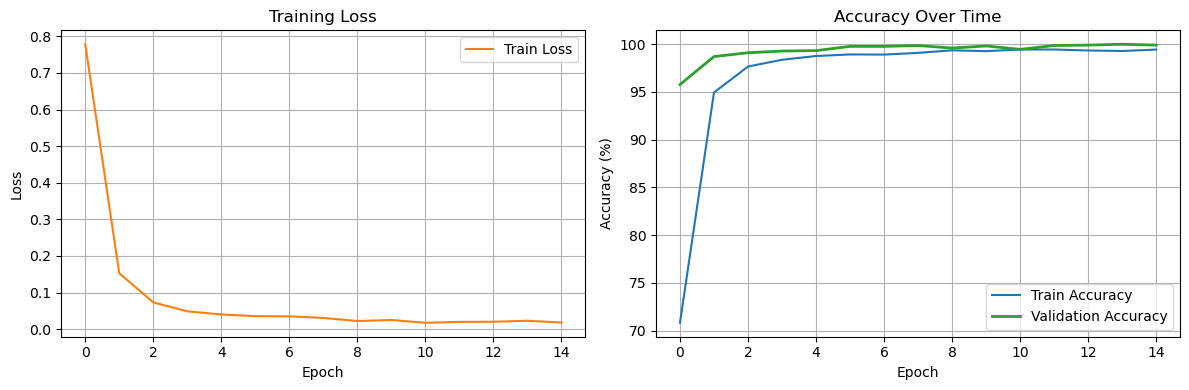

In [11]:
# Training history plot

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss', color='tab:orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy', color='tab:blue')
plt.plot(val_accuracies, label='Validation Accuracy', color='tab:green', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Over Time')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Test Accuracy: 100.00%


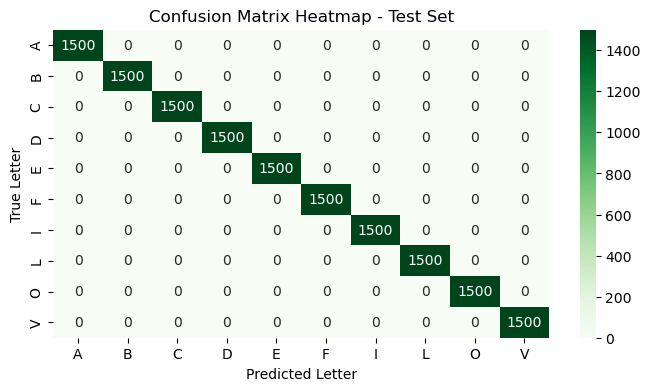

In [12]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score
import numpy as np

model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate accuracy
test_accuracy = accuracy_score(all_labels, all_preds) * 100
print(f"Test Accuracy: {test_accuracy:.2f}%")

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot beautiful heatmap
plt.figure(figsize=(8, 4))
sns.heatmap(cm, annot=True, fmt='g', cmap='Greens',
            xticklabels=selected_classes,
            yticklabels=selected_classes)
plt.title('Confusion Matrix Heatmap - Test Set')
plt.xlabel('Predicted Letter')
plt.ylabel('True Letter')
plt.show()

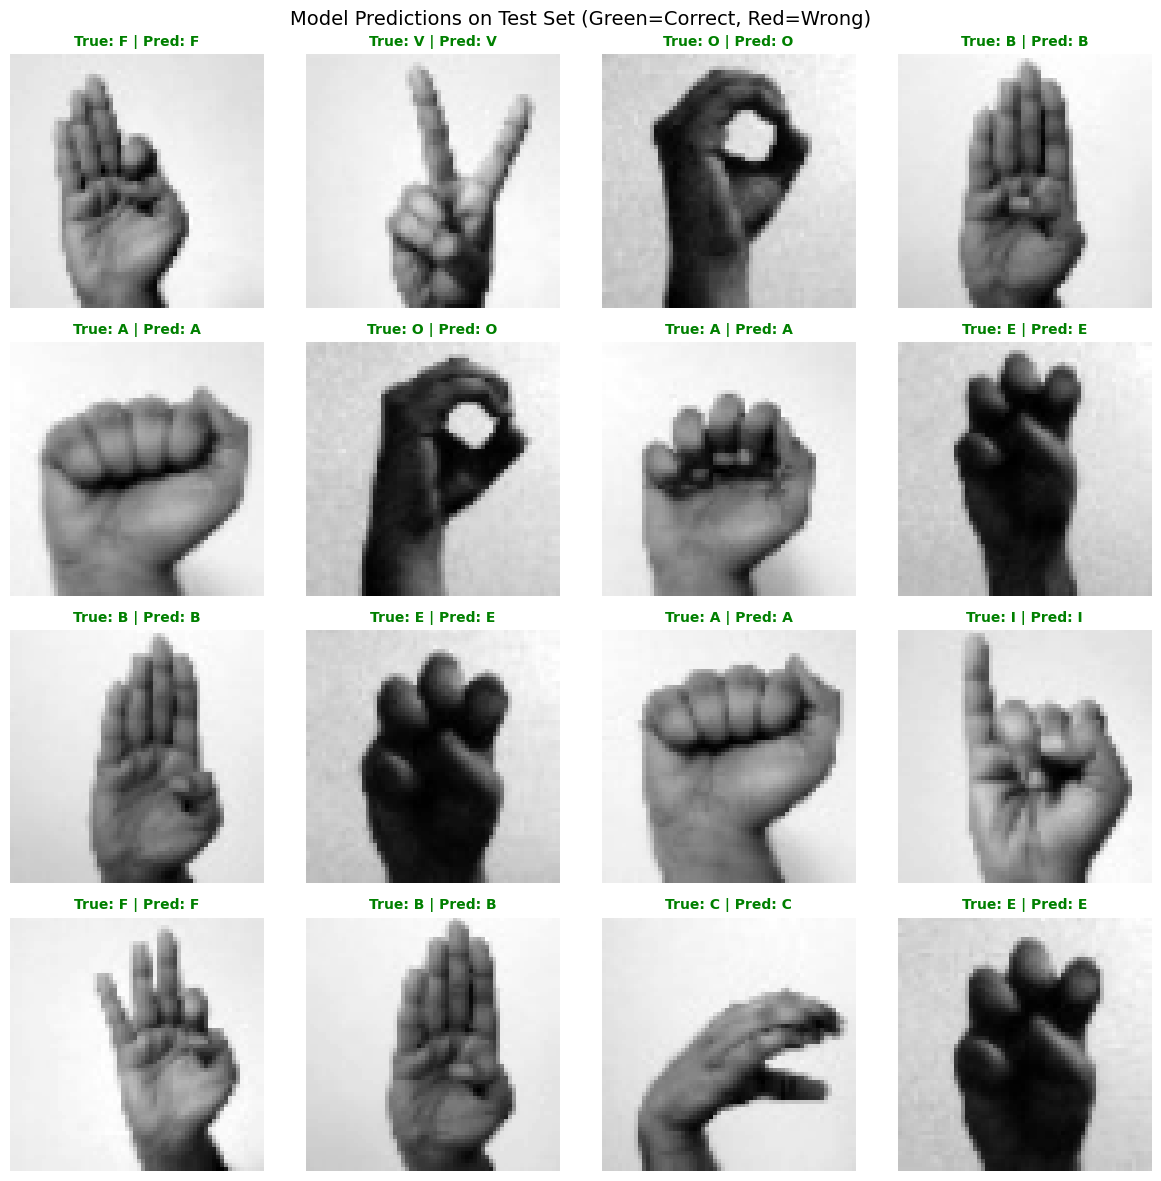

In [13]:
# Prediction Results (Test Set)

def show_predictions(model, test_loader, num_images=16):
    model.eval()
    images, labels = next(iter(test_loader))
    images, labels = images.to(device), labels.to(device)
    
    with torch.no_grad():
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
    
    # Un-normalize and plot
    images = (images.cpu() * 0.5 + 0.5).clamp(0, 1).squeeze(1)
    
    fig, axes = plt.subplots(4, 4, figsize=(12, 12))
    for i, ax in enumerate(axes.flat):
        if i < num_images:
            ax.imshow(images[i], cmap='gray')
            true_label = selected_classes[labels[i].item()]
            pred_label = selected_classes[predicted[i].item()]
            color = 'green' if true_label == pred_label else 'red'
            ax.set_title(f"True: {true_label} | Pred: {pred_label}", color=color, fontsize=10, fontweight='bold')
            ax.axis('off')
    plt.suptitle('Model Predictions on Test Set (Green=Correct, Red=Wrong)', fontsize=14)
    plt.tight_layout()
    plt.show()

# Create a shuffled test loader
vis_test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

# Show predictions
show_predictions(model, vis_test_loader)

<h4 style="color:darkred;">Save Model</h4>

In [14]:
# Save the entire model (architecture + weights)
model_save_path = "asl_gesture_cnn_10classes_full.pth"

torch.save(model, model_save_path)  # Saves everything
print(f"Full model saved as '{model_save_path}'")

Full model saved as 'asl_gesture_cnn_10classes_full.pth'
